<a href="https://colab.research.google.com/github/Mitchell-Odili/Stanford-Cars-Image-Classification/blob/main/stanford_cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('stanford-cars')
jovian.set_colab_id('1nWbXnSz53GDNc4TcGXZi8SYhRcOQVroC')

# Stanford-cars Image Classification

![](https://www.motortrend.com/uploads/sites/5/2019/12/MotorTrend-Most-Important-Cars-of-the-Decade.jpg?fit=around%7C875:492)

The objective of this notebook is to showcase the use of Deep Neural Networks in a real life classification project scenario and to display how powerful and applicable pretrained Neural Networks are.

 To achieve that we will seek to successfully classify `Stanford Cars` into their rightful classes. We'll use the `Stanford Cars` dataset from https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder .We have 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year.

In this notebook you will find
1. Convolutional Neural Networks
2. Data Augmentation, Regularization and ResNets 
3. The `ResNet 9 Model` built from scratch
4. Modification and Utilization of pretrained resnet models i.e. `Resnet34`

## Downloading the Dataset



We can use the [`opendatasets`](https://github.com/JovianML/opendatasets) library to download the [dataset](https://www.kaggle.com/splcher/animefacedataset) from Kaggle. `opendatasets` uses the [Kaggle Official API](https://github.com/Kaggle/kaggle-api) for downloading datasets from Kaggle. 

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder'
od.download(dataset_url)

100%|██████████| 1.83G/1.83G [00:52<00:00, 37.2MB/s]


In [ ]:
from torch.utils.data import Dataset

In [ ]:
import os

DATA_DIR_TRAIN = './stanford-car-dataset-by-classes-folder/car_data/car_data/train'
train_classes = os.listdir(DATA_DIR_TRAIN)

DATA_DIR_TEST = './stanford-car-dataset-by-classes-folder/car_data/car_data/test'
test_classes = os.listdir(DATA_DIR_TEST)

train_classes[:5], test_classes[:5]

(['Audi V8 Sedan 1994',
  'Ferrari California Convertible 2012',
  'Jeep Liberty SUV 2012',
  'Chevrolet Corvette ZR1 2012',
  'Nissan NV Passenger Van 2012'],
 ['Audi V8 Sedan 1994',
  'Ferrari California Convertible 2012',
  'Jeep Liberty SUV 2012',
  'Chevrolet Corvette ZR1 2012',
  'Nissan NV Passenger Van 2012'])

In [ ]:
# Tie the class indices to their names

def find_classes(dir):
    train_classes = os.listdir(dir)
    train_classes.sort()
    train_class_to_idx = {train_classes[i]: i for i in range(len(train_classes))}
    return train_classes, train_class_to_idx
    test_class_to_idx = {test_classes[i]: i for i in range(len(test_classes))}
    return test_classes, test_class_to_idx

train_classes, train_c_to_idx = find_classes(DATA_DIR_TRAIN)
test_classes, test_c_to_idx = find_classes(DATA_DIR_TEST)

In [ ]:
train_classes[:5], test_classes[:5]

(['AM General Hummer SUV 2000',
  'Acura Integra Type R 2001',
  'Acura RL Sedan 2012',
  'Acura TL Sedan 2012',
  'Acura TL Type-S 2008'],
 ['AM General Hummer SUV 2000',
  'Acura Integra Type R 2001',
  'Acura RL Sedan 2012',
  'Acura TL Sedan 2012',
  'Acura TL Type-S 2008'])

In [ ]:
len(train_classes), len(test_classes)

(196, 196)

In [ ]:
train_classes == test_classes

True

In [ ]:
# Tie the class indices to their names

def find_classes(dir):
    test_classes = os.listdir(dir)
    test_classes.sort()
    test_class_to_idx = {test_classes[i]: i for i in range(len(test_classes))}
    return test_classes, test_class_to_idx
test_classes, test_c_to_idx = find_classes(DATA_DIR_TEST)

In [ ]:
def extract_class(Datasets):
  for vals in os.listdir(Datasets):
    print(vals)

In [ ]:
extract_class(DATA_DIR_TRAIN)

Audi V8 Sedan 1994
Ferrari California Convertible 2012
Jeep Liberty SUV 2012
Chevrolet Corvette ZR1 2012
Nissan NV Passenger Van 2012
Lamborghini Aventador Coupe 2012
Infiniti QX56 SUV 2011
FIAT 500 Convertible 2012
GMC Canyon Extended Cab 2012
Dodge Dakota Crew Cab 2010
Bentley Mulsanne Sedan 2011
Hyundai Genesis Sedan 2012
Ford F-150 Regular Cab 2012
Bugatti Veyron 16.4 Convertible 2009
Plymouth Neon Coupe 1999
smart fortwo Convertible 2012
Scion xD Hatchback 2012
Chevrolet Silverado 1500 Classic Extended Cab 2007
Spyker C8 Convertible 2009
Dodge Challenger SRT8 2011
Nissan Leaf Hatchback 2012
Land Rover Range Rover SUV 2012
Dodge Sprinter Cargo Van 2009
Dodge Caliber Wagon 2012
Chevrolet Silverado 1500 Regular Cab 2012
Hyundai Veloster Hatchback 2012
Infiniti G Coupe IPL 2012
Mercedes-Benz E-Class Sedan 2012
Suzuki Kizashi Sedan 2012
GMC Savana Van 2012
Acura ZDX Hatchback 2012
Audi S5 Coupe 2012
Mercedes-Benz 300-Class Convertible 1993
Eagle Talon Hatchback 1998
Mercedes-Benz S-Cla

The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [ ]:
train_dataset = ImageFolder(DATA_DIR_TRAIN, transform = ToTensor())
test_dataset = ImageFolder(DATA_DIR_TEST, transform = ToTensor())

In [ ]:
len(train_dataset), len(test_dataset)

(8144, 8041)

The training and test datasets have 8144 and 8041 elements respectively. Let's look at a sample element from each. Each element is a tuple, containing an image tensor and a label. Since the data consists of X * Y (different sized) px color images with 3 channels (RGB), each image tensor has the shape `(3, X, Y)`.

In [ ]:
image, label = train_dataset[0]
print('image_shape:', image.shape, 'Label:',label)

image_shape: torch.Size([3, 525, 700]) Label: 0


In [ ]:
image, label = train_dataset[1]
print('image_shape:', image.shape, 'Label:',label)

image_shape: torch.Size([3, 64, 85]) Label: 0


The image tensors of element 0 and 1 from the train dataset are of different shapes i.e. `3 * 523 * 700` v/s `3 * 64 * 85` . 

We can view the images using `matplotlib`, but we need to change the tensor dimensions to `(X,Y,3)`. Let's create a helper function to display an image and its label.


In [ ]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  AM General Hummer SUV 2000 (0)


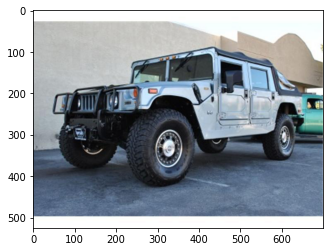

In [ ]:
show_example(*train_dataset[0])

Label:  Plymouth Neon Coupe 1999 (171)


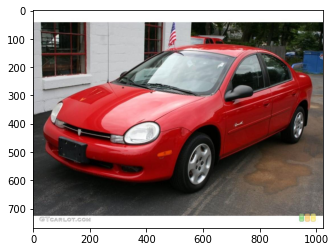

In [ ]:
show_example(*test_dataset[7030])

Label:  AM General Hummer SUV 2000 (0)


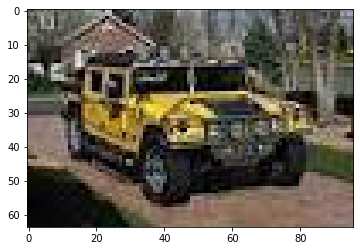

In [ ]:
show_example(*test_dataset[0])

To display batches of data in a grid, we need to normalize the dimensions of the images. Here we are using 256 x 256px images with normalization to yield `3 * 256 * 256`

In [ ]:
train_tfms = tt.Compose([tt.Resize((256, 256)),
                         tt.RandomRotation(0),
                         tt.ToTensor(),
                         tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = tt.Compose([tt.Resize((256, 256)),
                        tt.ToTensor(),
                        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_dataset = ImageFolder(DATA_DIR_TRAIN, transform = train_tfms)
test_dataset = ImageFolder(DATA_DIR_TEST, transform = test_tfms)

Let's look at the standardized/normalized/transformed datasets. The list of classes is stored in the `.classes` property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [ ]:
# Pick the last 4 from the training dataset
train_dataset.classes[-5:-1]

['Volkswagen Golf Hatchback 2012',
 'Volvo 240 Sedan 1993',
 'Volvo C30 Hatchback 2012',
 'Volvo XC90 SUV 2007']

In [ ]:
# Lift index 5: 9 in the test dataset
test_dataset.classes[5:9]

['Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012']

In [ ]:
len(train_dataset), len(test_dataset)

(8144, 8041)

The standardized training and test datasets have 8144 and 8041 elements respectively. Each element is a tuple, containing an image tensor and a label. Since the data consists of 256 * 256px color images with 3 channels (RGB), each image tensor has the shape `(3, 256, 256)`.



In [ ]:
image, label = train_dataset[0]
print('image_shape:', image.shape, 'Label:',label)

image_shape: torch.Size([3, 256, 256]) Label: 0


In [ ]:
image, label = test_dataset[7030]
print('image_shape:', image.shape, 'Label:',label)

image_shape: torch.Size([3, 256, 256]) Label: 171


We can view the images using `matplotlib`, but we need to change the tensor dimensions to `(256,256,3)`. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  AM General Hummer SUV 2000 (0)


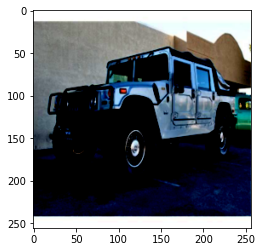

In [ ]:
show_example(*train_dataset[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Plymouth Neon Coupe 1999 (171)


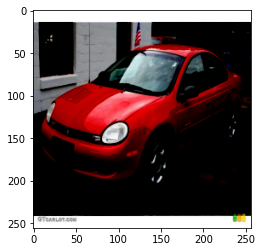

In [ ]:
show_example(*test_dataset[7030])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  AM General Hummer SUV 2000 (0)


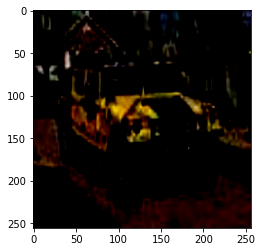

In [ ]:
show_example(*test_dataset[0]);

You can see the difference between the standardized and non-standardized images earlier due to normalization

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (10 percent of images) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_percent = 0.1
val_size = int(val_percent * len(train_dataset))
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(7330, 814)

The `jovian` library also provides a simple API for recording important parameters related to the dataset, model training, results etc. for easy reference and comparison between multiple experiments. Let's record `dataset_url`, `val_pct` and `rand_seed` using `jovian.log_dataset`.

In [ ]:
jovian.log_dataset(dataset_url = dataset_url, val_size = val_size, random_seed = random_seed)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Dataset logged.


We can now create data loaders for training and validation, to load the data in batches

In [ ]:
batch_size = 128

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size * 2, num_workers = 4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


We can look at batches of images from the dataset using the `make_grid` method from `torchvision`. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [ ]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (12,6))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


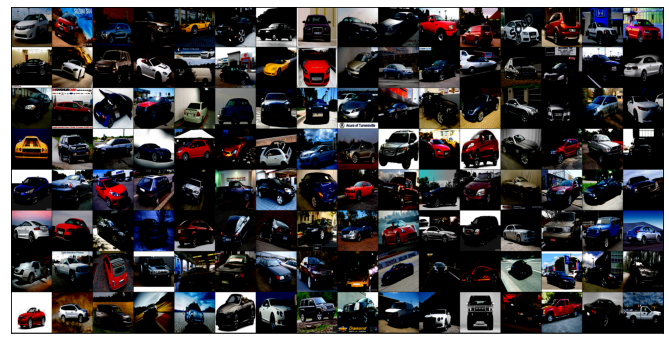

In [ ]:
show_batch(train_dl);

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


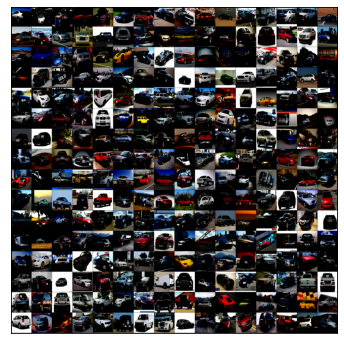

In [ ]:
show_batch(val_dl); 

Let's save and commit our work using `jovian` before proceeding further.

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="stanford-cars")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/mitchell-odili/stanford-cars


'https://jovian.ai/mitchell-odili/stanford-cars'

## Convolutional Neural Networks

We will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch

In [ ]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8, kernel_size = 3, stride = 1, padding = 1),
    nn.MaxPool2d(2,2)
)

In [ ]:
for images, labels in train_dl:
  print('images.shape:', images.shape)
  out = simple_model(images)
  print('out.shape:', out.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 256, 256])
out.shape: torch.Size([128, 8, 128, 128])


The `Conv2d` layer transforms a 3-channel image to an 8-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [ ]:
class StanfordCarsModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 16 x 128 x 128

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 64 x 64

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 32 x 32

            nn.Flatten(), 
            nn.Linear(64*32*32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 196))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = StanfordCarsModel()
model

StanfordCarsModel(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=65536, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1

Let's verify that the model produces the expected output on a batch of training data. The 196 outputs for each image can be interpreted as probabilities for the 196 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image. Check out [Part 3 (logistic regression)](https://jovian.ml/aakashns/03-logistic-regression#C50) for a more detailed discussion on interpeting the outputs, applying softmax and identifying the predicted labels.

In [ ]:
for images, labels in train_dl:
  print('images.shape:', images.shape)
  out = model(images)
  print('out.shape:', out.shape)
  print('out[0]:', out[0])
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 256, 256])
out.shape: torch.Size([128, 196])
out[0]: tensor([ 2.1798e-02, -1.5204e-02,  4.6250e-03, -3.0544e-02, -3.8073e-03,
        -2.8039e-02,  4.8566e-02,  1.4946e-02,  8.3471e-03,  3.7493e-02,
        -1.3038e-02, -3.6717e-02, -1.3989e-02,  1.4498e-02,  1.9505e-02,
        -1.3528e-02, -2.5837e-02,  2.6661e-02, -4.1389e-02, -2.7094e-02,
        -4.3256e-02,  3.0318e-02,  4.5738e-02, -2.5869e-02,  1.0035e-02,
         3.1076e-02,  3.5090e-02, -3.5105e-02, -3.0826e-02, -2.2223e-02,
         2.9261e-02,  2.0134e-03,  1.2163e-02, -4.5489e-02,  2.4741e-02,
        -6.5776e-05,  1.1286e-02,  2.4070e-02,  1.2962e-02, -1.4373e-02,
        -3.6612e-02, -2.0977e-02,  3.0480e-02, -5.0220e-02, -3.7621e-02,
         3.0301e-02,  4.6111e-03,  1.9273e-02, -1.8635e-02,  2.1344e-02,
         5.2925e-03, -3.1078e-02,  4.0403e-02, -3.3261e-02,  3.8229e-02,
        -3.3765e-02, -2.4655e-02,  3.1449e-02,  6.6232e-04,  3.4222e-02,
         1.0025e-02,  8.2900e-03,  2.

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. 

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

Once again, let's save and commit the notebook before we proceed further.

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/mitchell-odili/stanford-cars


'https://jovian.ai/mitchell-odili/stanford-cars'

## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. For a detailed walkthrough of these functions, check out the [previous tutorial](https://jovian.ai/aakashns/03-logistic-regression).

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [ ]:
model = to_device(StanfordCarsModel(), device)

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.00390625, 'val_loss': 5.278520584106445}

The initial accuracy is around 0.04%, which is what one might expect from a randomly intialized model (since it has a 1 in 196 chance of getting a label right by guessing randomly).

We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. As an exercise, you can try changing these to see if you have achieve a higher accuracy in a shorter time. 

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5e-2

It's important to record the hyperparameters of every experiment you do, to replicate it later and compare it against other experiments. We can record them using `jovian.log_hyperparams`.

In [ ]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 171024.4688, val_loss: 5.2919, val_acc: 0.0226
Epoch [1], train_loss: 5.2931, val_loss: 5.2896, val_acc: 0.0226
Epoch [2], train_loss: 5.2929, val_loss: 5.2987, val_acc: 0.0226
Epoch [3], train_loss: 5.2936, val_loss: 5.2956, val_acc: 0.0226
Epoch [4], train_loss: 5.2928, val_loss: 5.2883, val_acc: 0.0226
Epoch [5], train_loss: 5.2910, val_loss: 5.2885, val_acc: 0.0226
Epoch [6], train_loss: 5.2909, val_loss: 5.2926, val_acc: 0.0226
Epoch [7], train_loss: 5.2920, val_loss: 5.2959, val_acc: 0.0226
Epoch [8], train_loss: 5.2915, val_loss: 5.2967, val_acc: 0.0226
Epoch [9], train_loss: 5.2913, val_loss: 5.2935, val_acc: 0.0226


Just as we have recorded the hyperparameters, we can also record the final metrics achieved by the model using `jovian.log_metrics` for reference, analysis and comparison.

In [ ]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


We can also plot the valdation set accuracies to study how the model improves over time.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

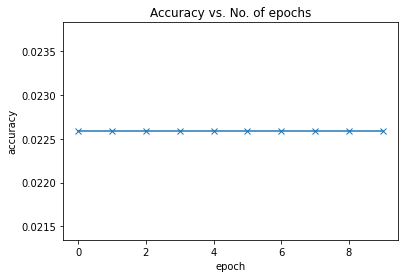

In [ ]:
plot_accuracies(history)

Our model reaches an accuracy of around 2.26%, and by looking at the graph, it seems unlikely that the model will achieve an accuracy higher than 2.26% even after training for a long time. This suggests that we might need to use a more powerful model to capture the relationship between the images and the labels more accurately. This can be done by adding more convolutional layers to our model, or incrasing the no. of channels in each convolutional layer, or by using regularization techniques.

We can also plot the training and validation losses to study the trend.

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

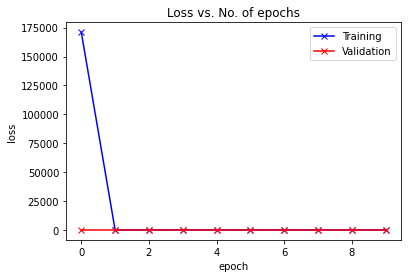

In [ ]:
plot_losses(history)

Before continuing, let us save our work to the cloud using `jovian.commit`.

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/mitchell-odili/stanford-cars


'https://jovian.ai/mitchell-odili/stanford-cars'

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 8041 images. We begin by creating a test dataset using the `ImageFolder` class.


In [ ]:
test_dataset = ImageFolder(DATA_DIR_TEST, transform = test_tfms)

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: AM General Hummer SUV 2000 , Predicted: GMC Savana Van 2012


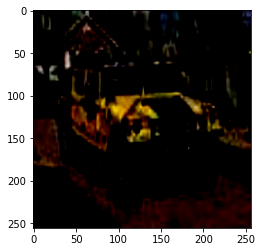

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Audi V8 Sedan 1994 , Predicted: GMC Savana Van 2012


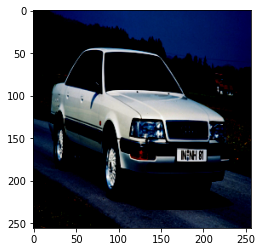

In [ ]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Lamborghini Diablo Coupe 2001 , Predicted: GMC Savana Van 2012


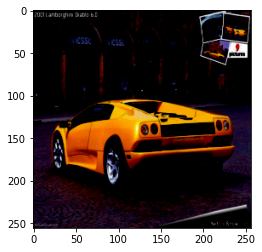

In [ ]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set, and record using `jovian`. We expect these values to be similar to those for the validation set. If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.00830078125, 'val_loss': 5.276653289794922}

In [ ]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Metrics logged.


## Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights of the model to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [ ]:
torch.save(model.state_dict(), 'stanfordcars-cnn.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model. To load the model weights, we can redefine the model with the same structure, and use the `.load_state_dict` method.

In [ ]:
model2 = to_device(StanfordCarsModel(), device)

In [ ]:
model2.load_state_dict(torch.load('stanfordcars-cnn.pth'))

<All keys matched successfully>

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before.

In [ ]:
evaluate(model2, test_loader)

{'val_acc': 0.00830078125, 'val_loss': 5.276653289794922}

Let's make one final commit using `jovian`.

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/mitchell-odili/stanford-cars


'https://jovian.ai/mitchell-odili/stanford-cars'

# Data Augmentation, Regularization and ResNets

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.Resize((256, 256)),
                         tt.RandomRotation(0),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace = True)])
valid_tfms = tt.Compose([tt.Resize((256, 256)),
                        tt.ToTensor(),
                        tt.Normalize(*stats)])

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(DATA_DIR_TRAIN, train_tfms)
valid_ds = ImageFolder(DATA_DIR_TEST, valid_tfms)

Next, we can create data loaders for retrieving images in batches. We'll use a small batch size of 128 to utlize a sound portion of the GPU RAM. You can try increasing the batch size & restarting the kernel then reduce if you face an "out of memory" error.

In [ ]:
batch_size = 128

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's take a look at some sample images from the training dataloader. To display the images, we'll need to _denormalize_ the pixels values to bring them back into the range `(0,1)`.

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


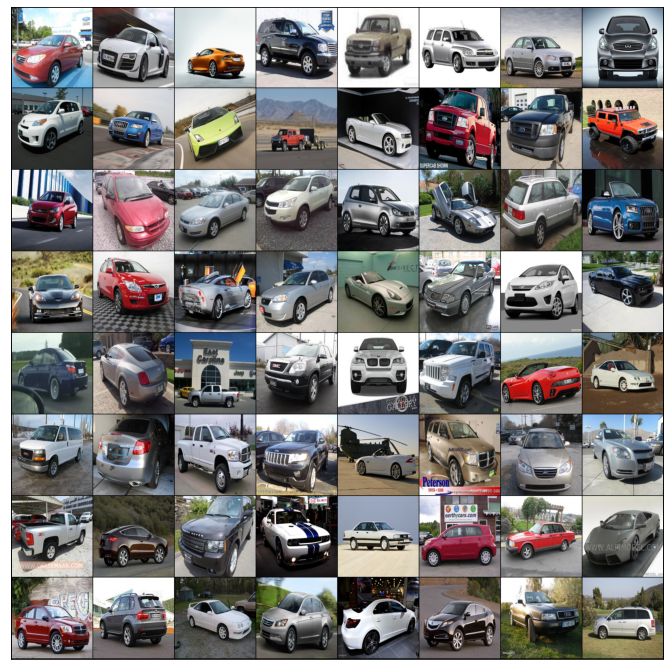

In [ ]:
show_batch(train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


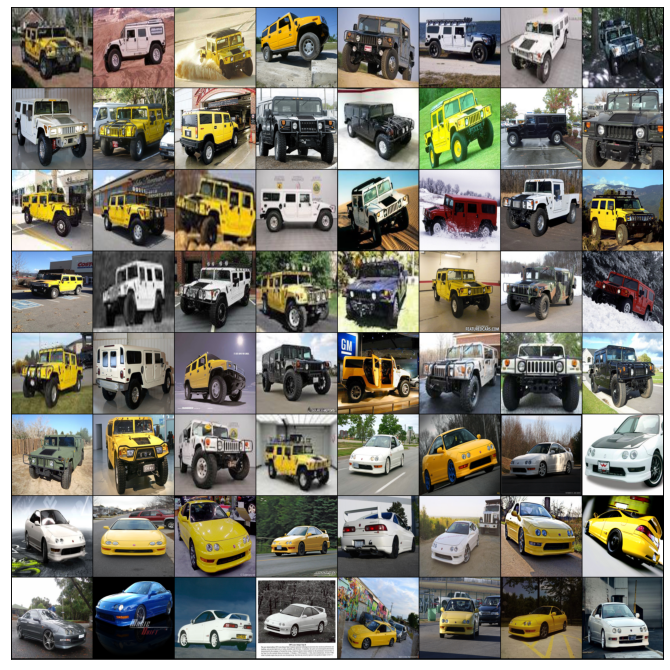

In [ ]:
show_batch(valid_dl)

The images seem compressed because of the normalization. Note that normalization is also applied during inference.

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. 

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

Here is a very simple Residual block:

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 3, 256, 256])


In [ ]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in valid_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 3, 256, 256])


This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer. 

Go through the following blog posts to learn more:

* Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 196), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
'''history = [evaluate(model, valid_dl)]
history'''

'history = [evaluate(model, valid_dl)]\nhistory'

We ran out of GPU RAM in evaluating the RESNET 9 model created from scratch. We will therefore modify a pretrained model - RESNET34. Which in true sense will yield high predictive power

## Modifying a Pretrained Model (ResNet34)

Transfer learning ([source](https://mc.ai/transfer-learning-with-deep-learning-machine-learning-techniques/)):
![transfer-learning](https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png)

In [ ]:
from torchvision import models

class StanfordCarsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

## GPU Utilities and Training Loop

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Finetuning the Pretrained Model

In [ ]:
model = StanfordCarsModel(len(train_dataset.classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
model

StanfordCarsModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.00452473945915699, 'val_loss': 5.47194766998291}]

The validation accuracy is `0.5%` with random parameters assigned. Sensical as we're looking at 196 classes

In [ ]:
epochs = 12
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4

opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00002, train_loss: 5.4408, val_loss: 5.2943, val_acc: 0.0077


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00006, train_loss: 4.9023, val_loss: 4.5460, val_acc: 0.1429


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00009, train_loss: 3.8027, val_loss: 3.4239, val_acc: 0.4003


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00010, train_loss: 2.4488, val_loss: 2.4793, val_acc: 0.6157


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00009, train_loss: 1.2319, val_loss: 1.8716, val_acc: 0.7094


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00008, train_loss: 0.4991, val_loss: 1.6603, val_acc: 0.7366


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00006, train_loss: 0.2082, val_loss: 1.4900, val_acc: 0.7559


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00005, train_loss: 0.1178, val_loss: 1.4201, val_acc: 0.7655


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00003, train_loss: 0.0846, val_loss: 1.3881, val_acc: 0.7672


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00001, train_loss: 0.0717, val_loss: 1.3800, val_acc: 0.7690


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00000, train_loss: 0.0658, val_loss: 1.3825, val_acc: 0.7700


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00000, train_loss: 0.0636, val_loss: 1.3784, val_acc: 0.7689
CPU times: user 15min 7s, sys: 10min 16s, total: 25min 24s
Wall time: 51min 31s


[link text](https://)The pretrained model reaches an accuracy of `~77%` in 51 min. Wonderful

It's important to record the hyperparameters of every experiment you do, to replicate it later and compare it against other experiments. We can record them using `jovian.log_hyperparams.`

In [ ]:
jovian.reset()
jovian.log_hyperparams({
    'epochs': epochs,
    'max_lr': max_lr,
    'grad_clip': grad_clip,
    'weight_decay': weight_decay,
    'opt_func': opt_func.__name__  
})

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/mitchell-odili/stanford-cars


'https://jovian.ai/mitchell-odili/stanford-cars'

## Testing with individual images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: AM General Hummer SUV 2000 , Predicted: AM General Hummer SUV 2000


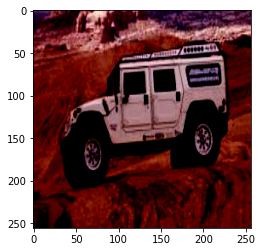

In [ ]:
img, label = test_dataset[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Audi TT RS Coupe 2012 , Predicted: Audi TT RS Coupe 2012


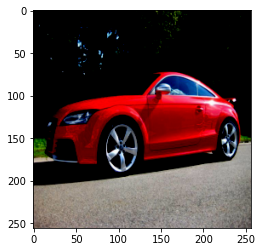

In [ ]:
img, label = test_dataset[919]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Lamborghini Diablo Coupe 2001 , Predicted: Lamborghini Diablo Coupe 2001


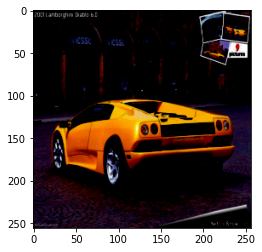

In [ ]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

# Conclusion

In this notebook, we built Convolutional Neural Networks and used various advanced techniques like Normalization, Data Augmentation, Regularization, Residual connections, etc wih our batches of data, to perform Image Classification for the `Stanford Cars Dataset`. We built some models from scratch, and utilized other pretrained models with higher predictive capabilities and accuracy

Eventually, we modified the ResNet34 model for our Stanford cars image classification and we got a fairly good accuracy of over 67%. (with 196 classes.)

This notebook shows the power of pretrained models and their applicability in Deep Learning. Where we didn't have enough RAM Space to build complex architecture models from scratch, pretrained models such as `resnet34` allowed us to improve the predictive power of this classification model significantly



# Future Work

There's lots of scope for future work and improvement even on this model like using different network architectures, hyperparameters, optimizers and gathering more training data to further increase the accuracy and make our model more robust. 

Deep Neural Networks could find a lot of use in 
1. Classification: e.g. Image Classification problems in the healthsector such as bio medical imaging analysis, Diagnostics, etc among multiple uses in multiple other sectors 
2. Regression  etc 

All of which contribute towards the advancement of humanity by improving the quality of life, speeding up analysis and generating remarkable insight by poring through gigantic Terrabytes of data in such a short while

# References

1. https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans
2. https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder

## Saving and loading the model

In [ ]:
torch.save(model.state_dict(), 'stanfordcars-cnn.pth')

In [ ]:
model2 = to_device(StanfordCarsModel(len(train_dataset.classes)), device)

In [ ]:
model2.load_state_dict(torch.load('stanfordcars-cnn.pth'))

<All keys matched successfully>

Let's make one final commit using `jovian`.

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/mitchell-odili/stanford-cars


'https://jovian.ai/mitchell-odili/stanford-cars'